In [161]:
import geopandas as gpd
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
from sklearn import cluster
import numpy as np
from rasterio.features import rasterize
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc

# Загрузка данных

In [2]:
# Загрузка данных
pass_to_file = r'C:\Users\Xiaomi\Desktop\заланиt_ТерраТех\заание_4_программирование\Программирование\S2B_MSIL2A_20200926T084719_N0214_R107_T37VCD_20200926T114459.SAFE\GRANULE\L2A_T37VCD_A018580_20200926T085042\IMG_DATA\R10m'
R = pass_to_file + '\T37VCD_20200926T084719_B02_10m.jp2'
G = pass_to_file + '\T37VCD_20200926T084719_B03_10m.jp2'
B = pass_to_file +'\T37VCD_20200926T084719_B04_10m.jp2'
N = pass_to_file +'\T37VCD_20200926T084719_B08_10m.jp2'

water_shp = 'water.shp'
other_shp = 'other.shp'



In [ ]:
band2 = rasterio.open( R, driver='JP2OpenJPEG') #blue
band3 = rasterio.open(G, driver='JP2OpenJPEG') #green
band4 = rasterio.open(B, driver='JP2OpenJPEG') #red
band8 = rasterio.open(N, driver='JP2OpenJPEG') #nir

In [4]:
band8.crs

CRS.from_epsg(32637)

#  Сохранение в единый тиф

In [6]:

with rasterio.open('STC.tif','w',driver='Gtiff',
                         width=band4.width, height=band4.height,
                         count=4,
                         crs=band4.crs,
                         transform=band4.transform,
                         dtype=band4.dtypes[0]
                         ) as trueColor:

    trueColor.write(band2.read(1),4) #blue
    trueColor.write(band3.read(1),3) #green
    trueColor.write(band4.read(1),2) #red
    trueColor.write(band8.read(1),1) #band8nir 




# создание обучающего набора данных на основе полигонов, которые были выделенны в qgis 

In [154]:
#создание набора данных с водой , класс 1 
with rasterio.open('STC.tif') as raster: 
    water = gpd.read_file(water_shp)  
    other = gpd.read_file(other_shp) 
    #Преобразование полигонов в маску с использованием границ растра
    #подготовка исходного растра 
    open_rastr = raster.read()

    raster_array = np.asarray([
            open_rastr[0, :, :].ravel(),
            open_rastr[1, :, :].ravel(),
            open_rastr[2, :, :].ravel(),
            open_rastr[3, :, :].ravel()
        ])
    mask_water = rasterize(shapes=water.geometry, out_shape=raster.shape, transform=raster.transform, fill=0, default_value=1)
    mask_other = rasterize(shapes=other.geometry, out_shape=raster.shape, transform=raster.transform, fill=1, default_value=0)

In [160]:
# проверка преобразований
print(open_rastr[0, :, :][1])
print(raster_array[0].reshape(open_rastr[0, :, :].shape)[1])
#проверил преобразования чтобы не запутаться 
print(raster_array[1])
print(open_rastr.reshape(4, -1)[1])

[2106 2555 2625 ... 1529 1599 1660]
[2106 2555 2625 ... 1529 1599 1660]
[ 333  325  340 ... 1044 1007  832]
[ 333  325  340 ... 1044 1007  832]


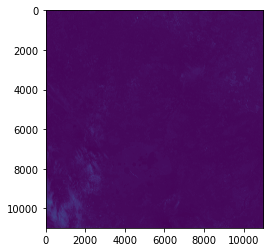

<AxesSubplot:>

In [318]:
#визуализация зелёного канала
plot.show(raster_array[1, :, :])

In [91]:
def format_data(array, mask1, mask2):
    filter = mask1.ravel() == 1
    filter2 = mask2.ravel() == 0
   
    X = np.concatenate((raster_array.T[filter], raster_array.T[filter2]), axis=0)
    y = np.concatenate((mask_water.ravel()[filter], mask_other.ravel()[filter2]), axis=0)

    return X, y  


In [92]:
X, y = format_data(raster_array,mask_water,mask_other)

In [104]:
#разбиваем на трейн и тест для выбора модели 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [107]:
def scor(model):
    # Прогнозируем значения тестовой выборки и оцениваем метрики качества
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Accuracy: {:.2f}, Recall: {:.2f}, Precision: {:.2f}, F1-score: {:.2f}".format(accuracy, recall, precision, f1))

In [ ]:
#обучение модели
model_RF = RandomForestClassifier(max_depth=9, random_state=42)
model_RF.fit(X_train, y_train)

In [108]:
#оценка точности
scor(model_RF)

Accuracy: 1.00, Recall: 1.00, Precision: 1.00, F1-score: 1.00


In [ ]:
# результат
res = model_RF.predict(raster_array.T)
#  возможно в задании необходимо было заполнить nan 
arr = np.where(res==1, np.nan, res)


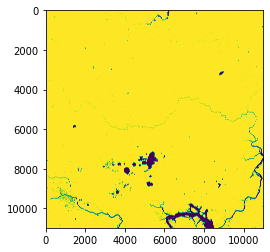

<AxesSubplot:>

In [113]:
plot.show((res-1).reshape(10980, 10980))

In [128]:
res = res.reshape(10980, 10980)

In [143]:
#Сохранение полученного растра
profile = raster.profile
profile['count']=1
with rasterio.open('res.tif', 'w', **profile) as dst:
        dst.write(res, indexes=1)

In [340]:
# любые простые модели работают достаточно точно для этой задачи поэтому подбирать гиперпараметры смысла нет 
model =  GradientBoostingClassifier(max_depth=100, random_state=42)
model.fit(X_train, y_train)
scor(model, X_test,y_test)

Accuracy: 1.00, Recall: 1.00, Precision: 0.99, F1-score: 0.99


# проверка с использованием Кросс-валидации

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

# Инициализируем объект KFold для разбиения данных на фолды
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# оценки с использованием кросс валидации 
accuracy_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
precision_scores = cross_val_score(model, X, y, cv=kf, scoring='precision')
recall_scores = cross_val_score(model, X, y, cv=kf, scoring='recall')
f1_scores = cross_val_score(model, X, y, cv=kf, scoring='f1')

# сравнение метрик качества 
print("Accuracy: {:.2f} (+/- {:.2f})".format(accuracy_scores.mean(), accuracy_scores.std() * 2))
print("Precision: {:.2f} (+/- {:.2f})".format(precision_scores.mean(), precision_scores.std() * 2))
print("Recall: {:.2f} (+/- {:.2f})".format(recall_scores.mean(), recall_scores.std() * 2))
print("F1-score: {:.2f} (+/- {:.2f})".format(f1_scores.mean(), f1_scores.std() * 2))

Подбор гиперпараметров 

In [145]:
from matplotlib.legend_handler import HandlerLine2D

def predict_score(name, param_list, model_clas ):
    train_results = []
    test_results = []
    for param in param_list:
        model = model_clas(param=param)
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    
    line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
    line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel(name)
    plt.show()




In [ ]:
# подбор параметров для улучшения модели 
max_depths = [int(i) for i in np.linspace(1, 32, 32, endpoint=True)]
predict_score('max_depths', max_depths,GradientBoostingClassifier )

min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
predict_score('min_samples_split', min_samples_splits,GradientBoostingClassifier)

min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
predict_score('min_samples_leafs', min_samples_leafs,GradientBoostingClassifier )

max_features = list(range(1,X.shape[1]))
predict_score('max_features', max_features,GradientBoostingClassifier)

In [ ]:
# Классифицируем исходную выборку
y_pred_full = model.predict(raster_array.reshape(-1,4))

# Выводим результаты классификации
print("Classification results:")
print(y_pred_full.reshape(10980, 10980))